In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import pandas as pd
import random
import numpy as np
import torch
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(7)

In [3]:
numerical_data = pd.read_csv('all_after_preprocessingStopwords.csv')

In [4]:
len(numerical_data)

10251

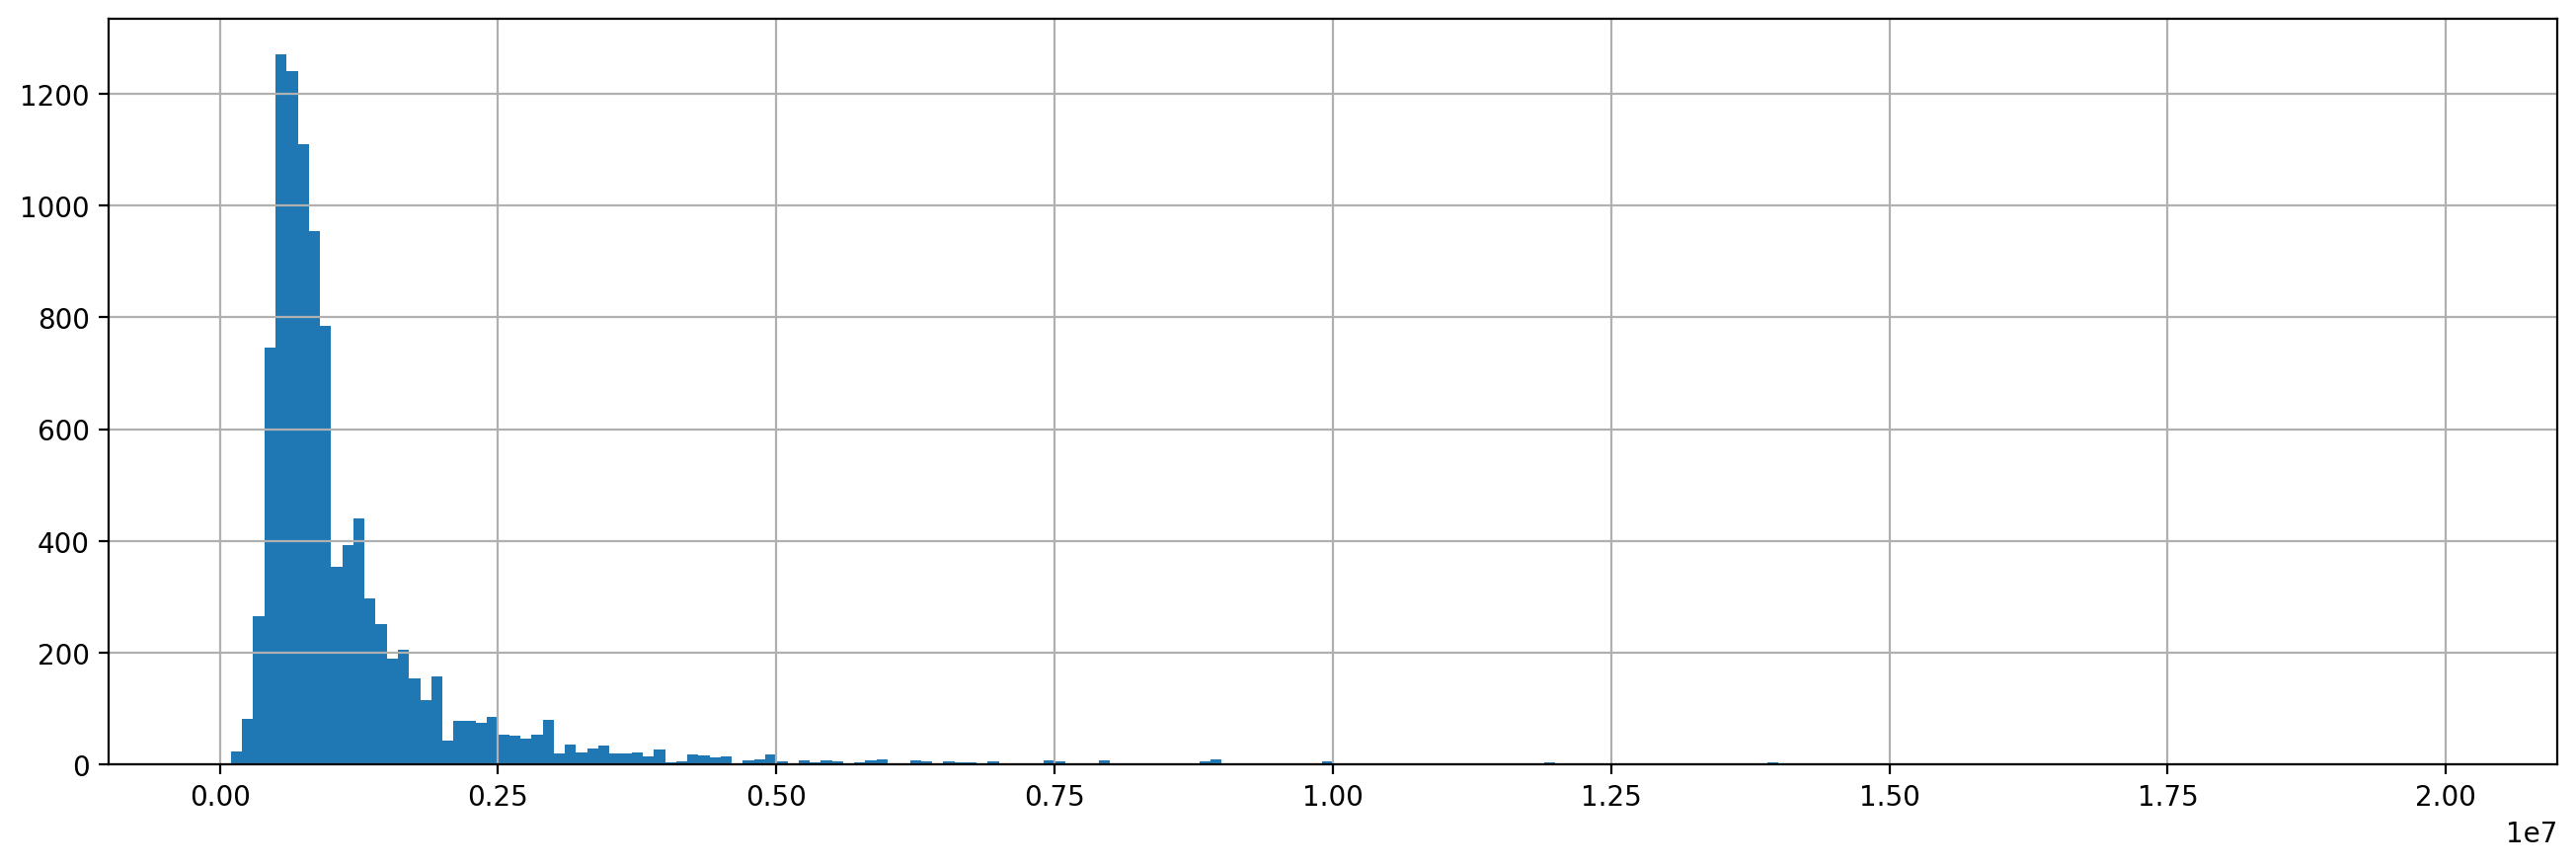

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,5), dpi=200)
plt.hist(numerical_data['price'], bins = 200, range = [0, 2e7])
plt.grid()
plt.show()

In [6]:
print(min(numerical_data['price']), max(numerical_data['price']))

87900 49000000


In [7]:
import numpy as np
from transformers import BertTokenizer,BertModel,get_linear_schedule_with_warmup, RobertaTokenizer, RobertaModel
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
def Data_preprocessing(df):
    scaler = MinMaxScaler()
    # Numerical Feature
    numerical_features = ["bedroom","bedroomAboveGrade","bedroomBelowGrade","bathroom", "bathroomTotal","bathroomPartial", 
                        "totalParkingSpaces", "storeys", "maintenanceFees",  'landSize']
    
    X_num = df[numerical_features]
    X_num = scaler.fit_transform(X_num)
    X_num = pd.DataFrame(X_num)
    df["longitude"] = df["longitude"] *0.01
    df["latitude"] = df["latitude"] *0.01
    df[numerical_features] = X_num
          
    # Boolean Feature
    boolean_features=['parkingAttachedGarage',
       'parkingUnderground', 'parkingInsideEntry', 'parkingSurfaced',
       'parkingOversize', 'parkingGravel', 'parkingGarage', 'parkingShared',
       'parkingDetachedGarage', 'parkingCarport', 'parkingInterlocked',
       'parkingVisitorParking','amenityClubhouse', 'amenityCarWash', 'amenityMusicRoom',
       'amenityStorageLocker', 'amenitySauna', 'amenityPartyRoom',
       'amenityRecreationCentre', 'amenityGuestSuite', 'amenityFurnished',
       'amenityLaundryFacility', 'amenityExerciseCentre',
       'amenityLaundryInSuite', 'amenitySecurity', 'amenityWhirlpool',
       'efinishWood', 'efinishBrick', 'efinishHardboard', 'efinishWoodsiding',
       'efinishLog', 'efinishMetal', 'efinishSteel', 'efinishStone',
       'efinishWoodshingles', 'efinishStucco', 'efinishSiding',
       'efinishConcrete', 'efinishShingles', 'efinishAluminumsiding',
       'efinishCedarshingles', 'efinishVinyl', 'efinishVinylsiding',
       'featurePetNotAllowed', 'AirportNearby',
       'GolfNearby', 'MarinaNearby', 'ShoppingNearby', 'WaterNearby',
       'WorshipPlaceNearby', 'RecreationNearby', 'PlaygroundNearby',
       'PublicTransitNearby', 'ParkNearby', 'SchoolsNearby', 'HospitalNearby',
       'HighwayNearby', 'SkiAreaNearby']
    
    # Category Feature
    cate_features = ['city', 'typeBuilding', 'title', 'styleAttach', 
                   'cooling',  'basementType', 'basementFinish',
                   'heatingType1', 'heatingType2', 'heatingEnergy1', 'heatingEnergy2', 
                   'featureLotSlope', 'featureDriveway', 'featureLotPositionType',
       'featureOutdoorAreaType', 'featureOutdoorLandscape',
       'featureAdditionalFacility']
    
    X_category=df[cate_features]
    for col in cate_features:
        X_category[col] = X_category[col].astype('category')
        X_category[col] = X_category[col].cat.codes
    df[cate_features] = X_category
    
    # Label Price
    price_range = []
    
    
    for price in df["price"]:
        if price < 5e5:
            price_range.append(0)
        elif 5e5<=price < 15e5:
            price_range.append(1)
        elif 15e5<=price < 25e5:
            price_range.append(2)
        elif 25e5<=price < 35e5:
            price_range.append(3)
        elif 35e5<=price < 80e5:
            price_range.append(4)
        else:
            price_range.append(5)
#     df = df.reset_index(drop=True)
    df['price_range'] = price_range
    df = df.dropna()
    return df, boolean_features, cate_features, numerical_features

In [8]:
preprocessed_data,boolean_features, cate_features, numerical_features = Data_preprocessing(numerical_data)

<ipython-input-7-81300e760d72>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_category[col] = X_category[col].astype('category')
<ipython-input-7-81300e760d72>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_category[col] = X_category[col].cat.codes


In [9]:
cate_num = len(cate_features)
bool_num =  len(boolean_features)
num_num = len(numerical_features)
print('The number of categorical feature is : {}, boolean feature is : {}, numerical feature is : {}'.format(cate_num, bool_num, num_num))

The number of categorical feature is : 17, boolean feature is : 58, numerical feature is : 10


In [10]:
preprocessed_data.groupby(['price_range']).size()

price_range
0    1119
1    7087
2    1179
3     425
4     341
5      92
dtype: int64

In [11]:
price_num = preprocessed_data["price"]
price_range = preprocessed_data["price_range"]

In [12]:
numerical_feature = cate_features + boolean_features + numerical_features + ['description']
numerical_data = preprocessed_data[numerical_feature]

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(numerical_data, price_num, test_size=0.2, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=13)

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(numerical_data, price_range, test_size=0.2, random_state=13)
X_val_cls, X_test_cls, y_val_cls, y_test_cls = train_test_split(X_test_cls, y_test_cls, test_size=0.5, random_state=13)

In [14]:
import matplotlib.pyplot as plt
def visualize_evaluate(target, prediction):
    plt.figure(figsize=(16,5), dpi=200)
    plt.plot(range(len(target)), target)
    plt.plot(range(len(prediction)), prediction)
    plt.grid()
    plt.show()

## Gradient Boosting Model (numerical information)

In [15]:
X_train_GB = X_train.drop('description', axis = 1)
X_test_GB =  X_test.drop('description', axis = 1)

X_train_GB = np.asarray(X_train_GB).astype(np.float32)
X_test_GB = np.asarray(X_test_GB).astype(np.float32)

In [20]:
X_train_SVM = X_train_cls.drop('description', axis = 1)
X_test_SVM =  X_test_cls.drop('description', axis = 1)

X_train_SVM = np.asarray(X_train_SVM).astype(np.float32)
X_test_SVM = np.asarray(X_test_SVM).astype(np.float32)

## SVM Classifier

In [21]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train_SVM, y_train_cls)

SVC()

In [23]:
from sklearn.metrics import classification_report
prediction = clf.predict(X_test_SVM)
print(classification_report(y_test_cls, prediction))

              precision    recall  f1-score   support

           0       0.70      0.27      0.39       118
           1       0.71      0.98      0.82       707
           2       0.00      0.00      0.00       126
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00        34
           5       0.00      0.00      0.00         8

    accuracy                           0.71      1025
   macro avg       0.23      0.21      0.20      1025
weighted avg       0.57      0.71      0.61      1025



F:\conda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Tree Classifier

In [24]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_SVM, y_train_cls)

In [25]:
prediction = clf.predict(X_test_SVM)
print(classification_report(y_test_cls, prediction))

              precision    recall  f1-score   support

           0       0.54      0.55      0.54       118
           1       0.83      0.81      0.82       707
           2       0.33      0.34      0.34       126
           3       0.25      0.38      0.30        32
           4       0.39      0.32      0.35        34
           5       0.22      0.25      0.24         8

    accuracy                           0.69      1025
   macro avg       0.43      0.44      0.43      1025
weighted avg       0.70      0.69      0.70      1025



In [33]:
import numpy as np 
from sklearn import ensemble
params = {'n_estimators': 500,
          'max_depth': 6,
          'learning_rate': 0.02,
          'subsample': 0.8
         }

reg = ensemble.GradientBoostingRegressor(**params)
y_train_flat=np.ravel(y_train)
reg.fit(X_train_GB, y_train_flat)

GradientBoostingRegressor(learning_rate=0.02, max_depth=6, n_estimators=500,
                          subsample=0.8)

In [34]:
y_test_pred = reg.predict(X_test_GB)

In [35]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
r2_pred=r2_score(y_test, y_test_pred)
rmse_test=mean_squared_error(y_test, y_test_pred, squared=False)
print('Original Rmse:', rmse_test)
print('Target R2 Score', r2_pred)

Original Rmse: 985890.832628956
Target R2 Score 0.53035355632965


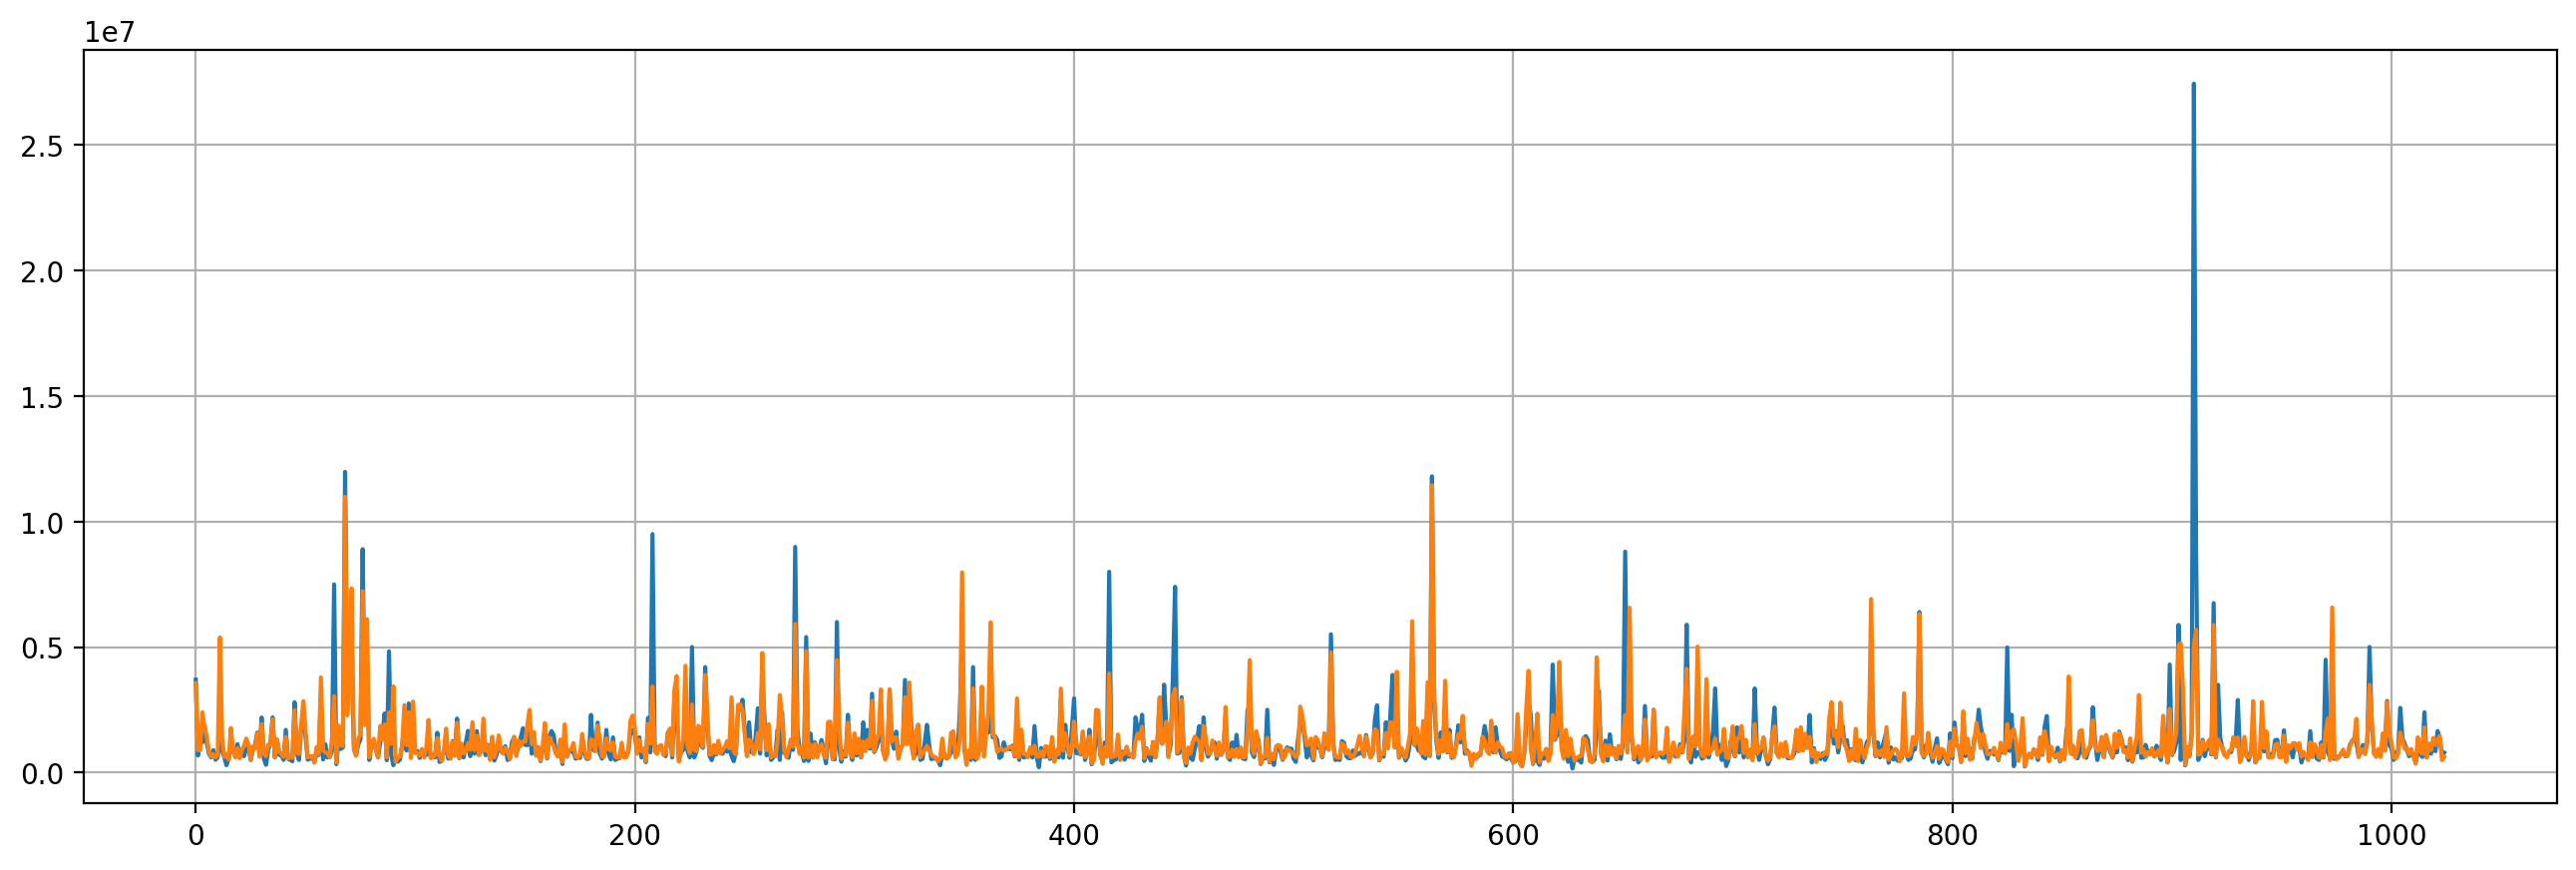

In [36]:
visualize_evaluate(y_test, y_test_pred)

## Gradient Boosting Model (numerical information + description information)

In [28]:
class Generate_dataset(Dataset):
    def __init__(self, data_df, tokenizer, boolean_features,cate_features, numerical_features, embedding_layer):
        self.MAX_SEQ_LEN = 128
        self.data = data_df
        self.tokenizer = tokenizer
        self.boolean = boolean_features
        self.cate = cate_features
        self.numerical = numerical_features
        self.embedding_layer = embedding_layer
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx): 
        if torch.is_tensor(idx):
            idx = idx.tolist()
        boolean_feature = torch.tensor(list(self.data.iloc[idx][self.boolean]))
        cate_feature = torch.tensor(list(self.data.iloc[idx][self.cate]))
        numerical_feature = torch.tensor(list(self.data.iloc[idx][self.numerical]))
        description = self.data.iloc[idx]['description']
        word_encode = torch.tensor(self.tokenizer.encode(text= description,max_length=self.MAX_SEQ_LEN,padding='max_length', truncation=True))
        word_embeddings_all = self.embedding_layer(word_encode.unsqueeze(0))
        word_embeddings = torch.mean(word_embeddings_all, dim = 1).squeeze()
        return torch.cat((word_embeddings, numerical_feature, cate_feature, boolean_feature), dim = -1)

In [31]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
Bert_embedding_layer = BertModel.from_pretrained("bert-base-uncased").embeddings.word_embeddings

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
Train_dataset = Generate_dataset(X_train, tokenizer, boolean_features,cate_features, numerical_features,Bert_embedding_layer)
Test_dataset = Generate_dataset(X_test, tokenizer, boolean_features,cate_features, numerical_features,Bert_embedding_layer)

In [33]:
Train_dataloader = DataLoader(Train_dataset, batch_size = len(Train_dataset))
Test_dataloader = DataLoader(Test_dataset, batch_size = len(Test_dataset))

In [34]:
Train_feature = np.array(next(iter(Train_dataloader)).tolist()).astype(np.float32)
Test_feature = np.array(next(iter(Test_dataloader)).tolist()).astype(np.float32)

<ipython-input-28-b7c23cdd675e>:16: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  boolean_feature = torch.tensor(list(self.data.iloc[idx][self.boolean]))


In [61]:
reg = ensemble.GradientBoostingRegressor(**params)
y_train_flat=np.ravel(y_train)
reg.fit(Train_feature, y_train_flat)

GradientBoostingRegressor(learning_rate=0.02, max_depth=6, n_estimators=500,
                          subsample=0.8)

In [62]:
y_test_pred = reg.predict(Test_feature)

In [63]:
r2_pred=r2_score(y_test, y_test_pred)
rmse_test=mean_squared_error(y_test, y_test_pred, squared=False)
print('Original Rmse:', rmse_test)
print('Target R2 Score', r2_pred)

Original Rmse: 1059379.0417337192
Target R2 Score 0.45772930527067834


## SVM

In [35]:
clf = svm.SVC()
clf.fit(Train_feature, y_train_cls)

SVC()

In [37]:
prediction = clf.predict(Test_feature)
print(classification_report(y_test_cls, prediction))

              precision    recall  f1-score   support

           0       0.70      0.26      0.38       118
           1       0.71      0.98      0.82       707
           2       0.00      0.00      0.00       126
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00        34
           5       0.00      0.00      0.00         8

    accuracy                           0.71      1025
   macro avg       0.24      0.21      0.20      1025
weighted avg       0.57      0.71      0.61      1025



F:\conda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Tree

In [38]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(Train_feature, y_train_cls)

In [39]:
prediction = clf.predict(Test_feature)
print(classification_report(y_test_cls, prediction))

              precision    recall  f1-score   support

           0       0.42      0.41      0.41       118
           1       0.80      0.79      0.80       707
           2       0.30      0.30      0.30       126
           3       0.16      0.28      0.20        32
           4       0.50      0.32      0.39        34
           5       0.17      0.12      0.14         8

    accuracy                           0.65      1025
   macro avg       0.39      0.37      0.37      1025
weighted avg       0.66      0.65      0.65      1025

